In [10]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [11]:
#Notes signed and dated by KD are debugging, any unsigned notes are from the BVH lab as part of the orignal 
#script -KD 2023.08.03

import matplotlib.pyplot as plt
import lumicks.pylake as lk
import itertools
import ipywidgets
import numpy as np
import glob
import os
import shutil
# We use skimage to downsample the data
from skimage.measure import block_reduce
from statistics import mean
from statistics import median
from scipy.stats import sem
#from matplotlib_venn import venn2 #this line is used for making venn diagrams of interactions
#if you get an error here just add in the terminal from the python environment: pip intall matplotlib-venn
%matplotlib inline
# Use notebook if you're in Jupyter Notebook
%matplotlib notebook

In [16]:
filename = glob.glob('*.h5') #fetches filename assuming only one .h5 in notebook
if len(filename) == 1:
    print (filename[0])
else: 
    print ("too many or too few .h5 files")
    print(len(filename))
plt.close('all')#This closes any plots left open to save memory and loads up the .h5 file in folder
file = lk.File(str(filename[0]))    


20240402-141257 Kymograph 4 d2 2x.h5


In [17]:
forcex = file["Force HF"]["Force 1x"] #this cell downsamples the force to save memory and make it easier to visualize

# time traces (seconds)
time = forcex.timestamps/1e9
time = time - time[0]
sample_rate = forcex.sample_rate

downsampled_rate = 50 # Hz, this rate can be changed as needed

# downsample the force, nanostage position and time
forcex_downsamp = forcex.downsampled_by(int(sample_rate/downsampled_rate))
time_downsamp = forcex_downsamp.timestamps/1e9
time_downsamp = time_downsamp - time_downsamp[0]
kymowidget = lk.KymoWidgetGreedy
median_force = (median(forcex_downsamp.data))
_, kymo = file.kymos.popitem() #after defining the downsample rate earlier, this actually does the downsampling

data = file.kymos[kymosname[0]].get_image(channel="red")

#note this depends on the collection channel -- for Cy3 we use green -og comment on script
#adjusted value from file.kymos["11"] to value recognized, see cell above to use for debugging -KD 2023.08.04

downsample_factor = 1
data = block_reduce(data, (1, downsample_factor))
#rgb = kymo.rgb_image
kymo = file.kymos[kymosname[0]]

<IPython.core.display.Javascript object>


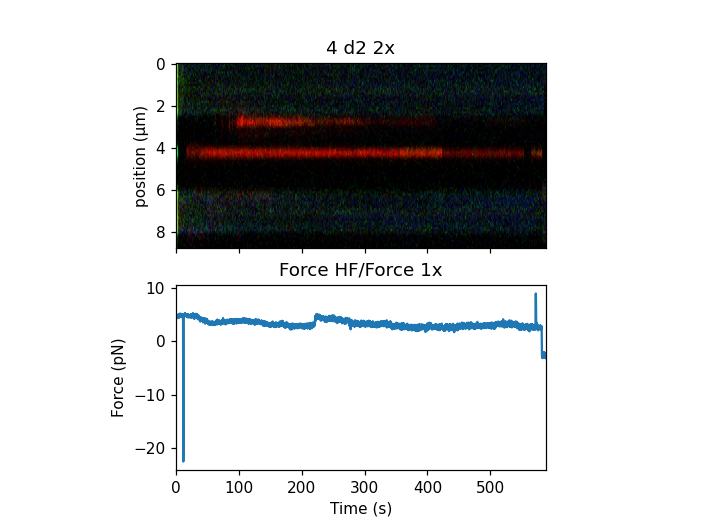

In [18]:
# define a color adjustment so we can see the data better
adjustment = lk.ColorAdjustment(0, 99.5, mode="percentile")

name, kymo = file.kymos.popitem()

kymo.plot_with_force("1x", "rgb", adjustment=adjustment, aspect_ratio=0.5)
plt.show()

In [19]:
pixel_size = kymo.pixelsize_um
pixel_size_int = pixel_size[0]

In [20]:
lk.KymoWidgetGreedy(kymo, 'rgb', aspect='auto', adjustment=adjustment,  min_length=4, pixel_threshold=5, window=7, sigma=1, vmax=2)
plt.show()
#this first plot is to look at the kymograph on the pixel scale in order to decide if an upper and lower bound need to be applied

In [21]:
crop_top = 2.3
crop_bottom = 6.2
#renamed these variables so that things run smoothly downstream -- MAS 9-6-23
adjusted_lower_bound = crop_top
adjusted_upper_bound = crop_bottom
steps_between_bounds = int((adjusted_upper_bound - adjusted_lower_bound) * 10) #defines number of 100 nm steps between bounds
downsample_factor = 1

kymo_crop = file.kymos[kymosname[0]].crop_by_distance(crop_top, crop_bottom)

#viewing the kymographs this way will show them after they are cropped
lk.KymoWidgetGreedy(kymo_crop, 'rgb', aspect='auto', adjustment=adjustment,  min_length=4, pixel_threshold=5, window=7, sigma=1, vmax=2)


In [22]:
#This cell for tracking lines with kymowidget greedy. It opens two views -- one with a fixed aspect ratio and one adjustable
#By saving and loading the lines as redkymotracks.txt, they can easily be swapped back and forth between views as needed. Also used a scaling color map. MAS 9-6-23
red_tracks = lk.KymoWidgetGreedy(kymo_crop.downsampled_by(downsample_factor), "red", aspect="auto", min_length=4, pixel_threshold=1, window=12, sigma=0.25, vmax=3, correct_origin=True, cmap='viridis')

#I prefer the auto aspect so I just commented this one out for now.
#kymowidget1 = lk.KymoWidgetGreedy(kymo_crop.downsampled_by(downsample_factor), "red", axis_aspect_ratio=2, min_length=4, pixel_threshold=1, window=7, sigma=0.25, vmax=2, correct_origin=True)

In [24]:
#Used this to replace the lines and save_lines functions below that have since been replaced with the 
#KymoTrackGroup tracks. Printed values should match, if they do not the analysis between the two is not the same.
#Be sure to load and save between the widgets, but ultimately kymowidget1, the 2nd one, is the one that I've
#chosen to export the .csv output required for further steps. The comma delimiter for the .csv is highly
#recommended as comma delimited .csv files can be opened with Excel -KD 2023.08.07


red_tracks.save_tracks('kymotracks.csv', delimiter = ',')

In [25]:
#Replaced the above two obsolete cells with these commands containing updated, non-depreciated
#parameters -KD 2023.08.07

numberofredlines=len(red_tracks.tracks)
print(numberofredlines)
numberofredbins = int(round(np.sqrt (numberofredlines)) )
print (numberofredbins)

3
2


<IPython.core.display.Javascript object>


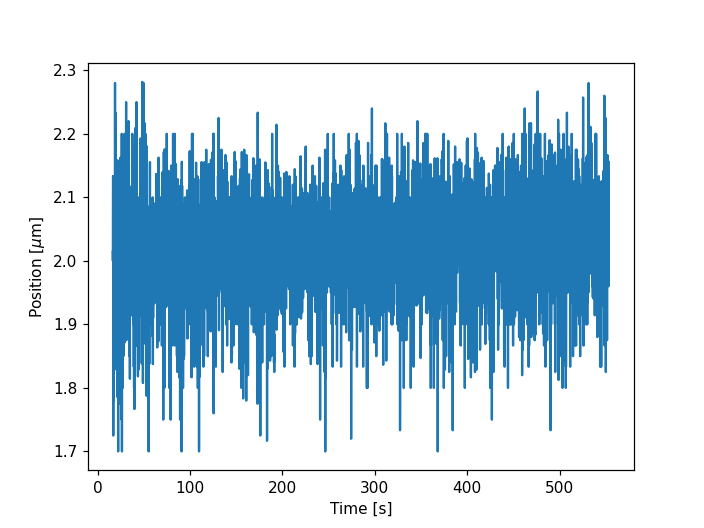

In [26]:
longest_track_idx = np.argmax([len(track) for track in red_tracks.tracks])  # Get the index of the longest track
longest_track = red_tracks.tracks[longest_track_idx]

plt.figure()
plt.plot(longest_track.seconds, longest_track.position)
plt.xlabel("Time [s]")
plt.ylabel("Position [$\mu$m]")
plt.show()

<IPython.core.display.Javascript object>


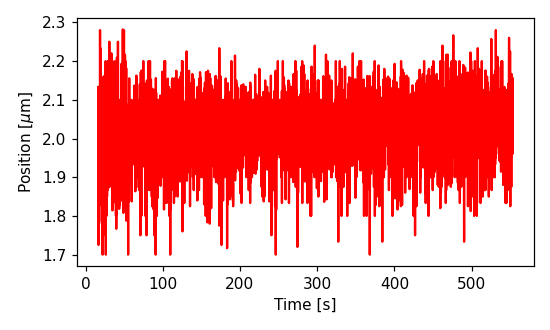

<IPython.core.display.Javascript object>


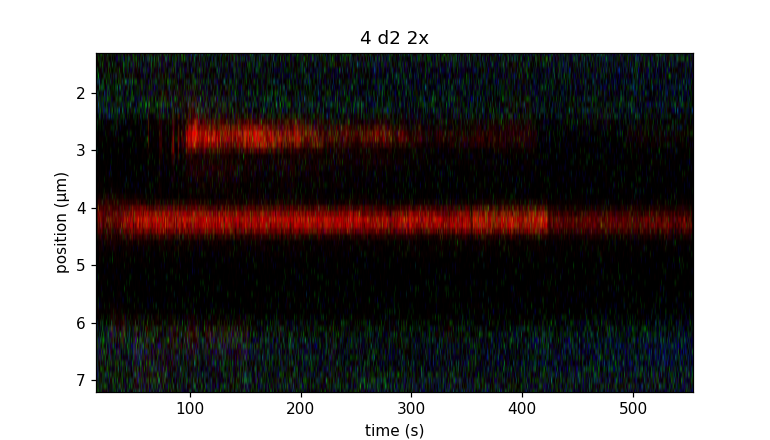

In [27]:
#red LINES SECTION--------------------------------------------------------------
redlengths = (track.time_idx[-1]-track.time_idx[0] for track in red_tracks.tracks)
# Get the index of the longest kymo line
redlongest_index = np.argmax(redlengths)

# Select the longest red line
redlongest_track = red_tracks.tracks[redlongest_index]
dt = kymo.line_time_seconds

#this section plots the positions of the longest line and also shows the raw image of that line 
#also leaves 1 second empty on each side so the start and end can be seen.
plt.figure(figsize=(5, 3))
plt.plot(np.array(redlongest_track.time_idx) * dt, np.array(redlongest_track.coordinate_idx ) * dt, color = 'red') 
plt.xlabel('Time [s]')
plt.ylabel('Position [$\mu$m]')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))

kymo.plot('rgb', aspect="auto", adjustment=adjustment)
plt.xlim([(np.array(redlongest_track.time_idx[0])) * dt -1, (np.array(redlongest_track.time_idx[-1])*dt +1 )])
plt.ylim(adjusted_upper_bound+1, adjusted_lower_bound-1) 
plt.show()

<IPython.core.display.Javascript object>


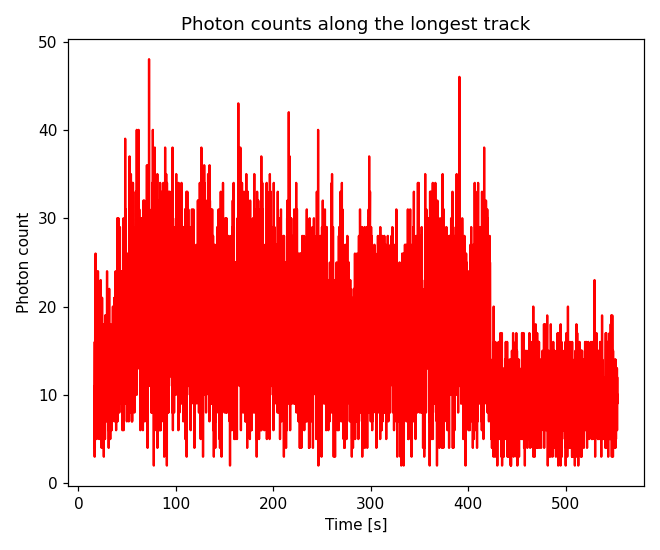

C:\Users\mas978\AppData\Local\Temp\ipykernel_17892\3384529405.py:4: RuntimeWarning: Prior to version 1.1.0 the method `sample_from_image` had a bug that assumed the origin of a pixel to be at the edge rather than the center of the pixel. Consequently, the sampled window could frequently be off by one pixel. To get the correct behavior and silence this warning, specify `correct_origin=True`. The old (incorrect) behavior is maintained until the next major release to ensure backward compatibility. To silence this warning use `correct_origin=False`.
  plt.plot( np.array(redlongest_track.time_idx) * dt, redlongest_track.sample_from_image(3), color='red') #this samples 3 pixels away from track position


<IPython.core.display.Javascript object>


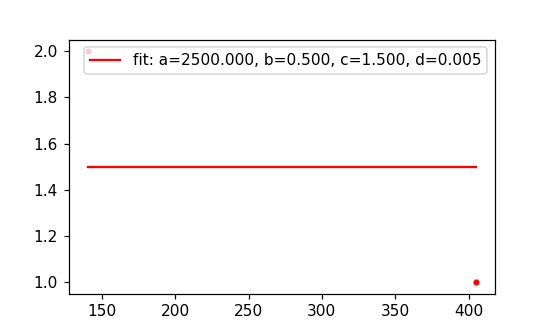

2.0


<IPython.core.display.Javascript object>


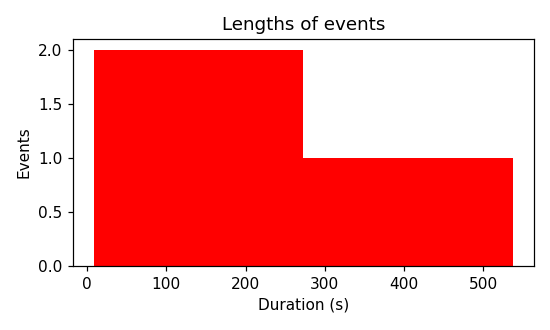

<IPython.core.display.Javascript object>


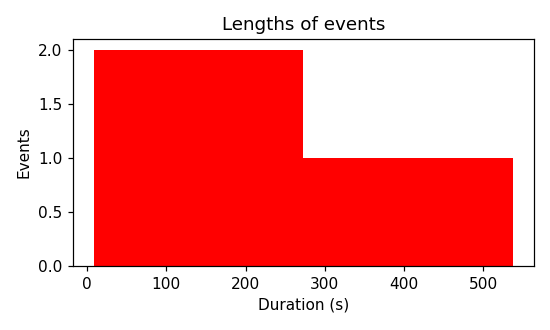

<IPython.core.display.Javascript object>


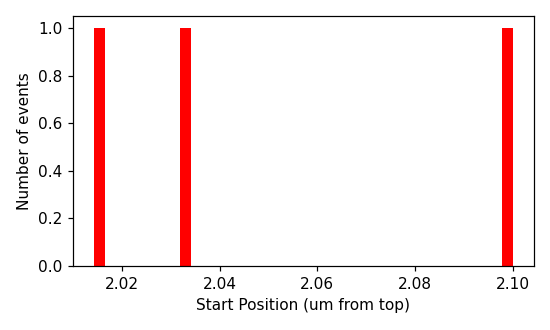

<IPython.core.display.Javascript object>


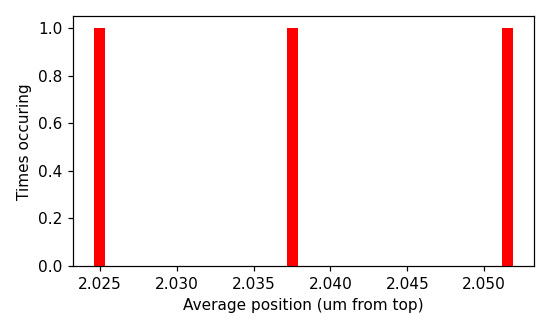

<IPython.core.display.Javascript object>


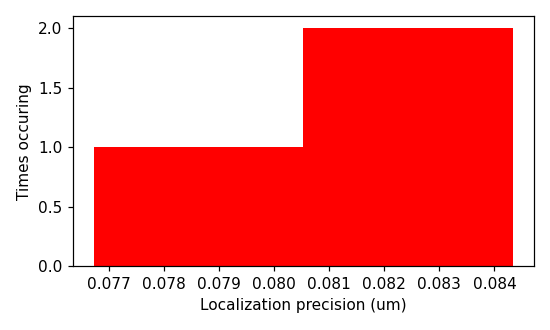

<IPython.core.display.Javascript object>


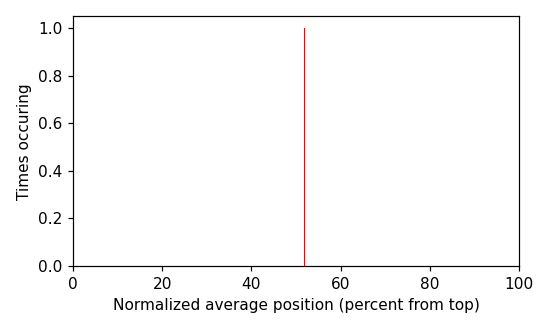

<IPython.core.display.Javascript object>


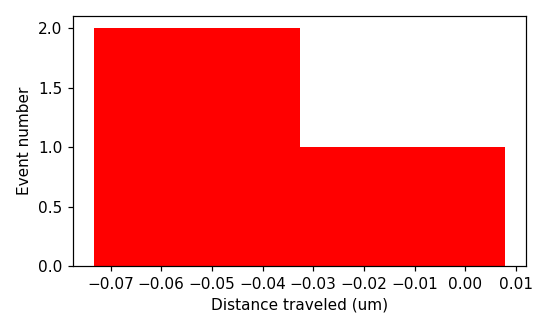

<IPython.core.display.Javascript object>


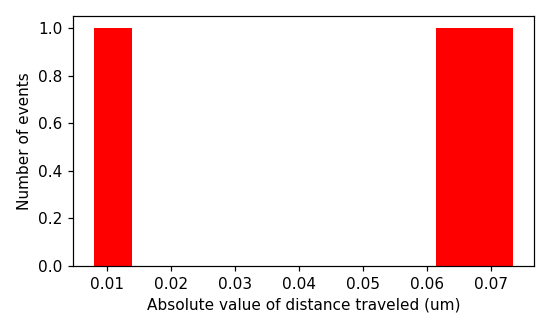

In [34]:
#THIS CELL FOR PROCESSING red CHANNEL DATA
#to plot photon count along the longest track
plt.figure(figsize=(6, 5))
plt.plot( np.array(redlongest_track.time_idx) * dt, redlongest_track.sample_from_image(3), color='red') #this samples 3 pixels away from track position
plt.ylabel('Photon count')
plt.xlabel('Time [s]')
plt.title('Photon counts along the longest track')
plt.tight_layout()
plt.show()

#fits the data to a single exponential decay
from scipy.optimize import curve_fit
def func(x, a, b, c,d):
    return a * np.exp(-b * (x-d)) + c 
redtimes = np.array([(track.time_idx[-1]-track.time_idx[0]) for track in red_tracks.tracks])*dt*downsample_factor 
counts,bins=np.histogram(redtimes, bins=numberofredbins)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
popt, pcov = curve_fit(func, binscenters, counts, bounds=(0, [5000, 1, 5, 0.01]))

plt.figure(figsize=(5,3))
plt.plot(binscenters,counts,'.', color='red')
plt.plot(binscenters, func(binscenters, *popt), 'r-',

         label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
redlifetime = 1 / popt[1]
print (redlifetime)
plt.legend()
plt.show()
# for this dataset, this translates to a t1/2 of 1 s (1/b = 1 s)

#plots track length as a histogram. numberofbins was defined earlier as square root of n
plt.figure(figsize=(5, 3))
plt.hist(redtimes, numberofredbins, color='red')
plt.ylabel('Events')
plt.xlabel('Duration (s)')
plt.title('Lengths of events')
plt.tight_layout()
plt.show()
#plots track length as a histogram. numberofbins was defined earlier as square root of n
plt.figure(figsize=(5, 3))
plt.hist(redtimes, numberofredbins, color='red')
plt.ylabel('Events')
plt.xlabel('Duration (s)')
plt.title('Lengths of events')
plt.tight_layout()
plt.show()


#histogram of starting positions for each track
redtime = [(track.time_idx[0]) * dt for track in red_tracks.tracks]
##np.array(longest_track.coordinate_idx) * pixel_size / 1000
startpositions = np.array([track.coordinate_idx[0] for track in red_tracks.tracks]) * pixel_size 
plt.figure(figsize=(5, 3))
plt.hist(startpositions, steps_between_bounds, color='red') #Arbitrarily defined a bunch of bins on this, roughly corresponding to 100 nm. This can be altegreen.
plt.xlabel('Start Position (um from top)')
plt.ylabel('Number of events')
plt.tight_layout()
plt.show()


#histogram of mean positions for each track
redmeanpositions = np.array([np.average(track.coordinate_idx) for track in red_tracks.tracks]) * pixel_size
plt.figure(figsize=(5, 3))
plt.hist(redmeanpositions, steps_between_bounds, color='red')
plt.xlabel('Average position (um from top)')
plt.ylabel('Times occuring')
plt.tight_layout()
plt.show()

#histogram of localization precision in um
redstandarddeviation = np.array([np.std(track.coordinate_idx, ddof=1) for track in red_tracks.tracks]) * pixel_size
plt.figure(figsize=(5, 3))
plt.hist(redstandarddeviation, numberofredbins, color='red')
plt.xlabel('Localization precision (um)')
plt.ylabel('Times occuring')
plt.tight_layout()
plt.show()
#this saves the MSD vlues as a .txt file in case we want to graph these in excel/prism. Still under development.
np.savetxt("std.txt", 
           redstandarddeviation,
           delimiter =", ",
            fmt = "%s")

#histogram of normalized track positions in terms of percentage along DNA bound. 
#To function properly, upper and lower bound must be defined as the edge of the beads.
rednorm_meanpositions = np.array([np.average(track.coordinate_idx) for track in red_tracks.tracks])  /(adjusted_upper_bound-adjusted_lower_bound) * 100 * pixel_size
plt.figure(figsize=(5, 3))
plt.hist(rednorm_meanpositions, steps_between_bounds, color='red')
plt.xlabel('Normalized average position (percent from top)')
plt.xlim(0, 100)
plt.ylabel('Times occuring')
plt.tight_layout()
plt.show()

#histogram of the difference between the start and endpoint of each track
reddistancetraveled = np.array([track.coordinate_idx[-1]-track.coordinate_idx[0] for track in red_tracks.tracks]) * pixel_size
plt.figure(figsize=(5, 3))
plt.hist(reddistancetraveled, numberofredbins, color='red')
plt.ylabel('Event number')
plt.xlabel('Distance traveled (um)')
plt.tight_layout()
plt.show()


#histogram of the absolute value of the difference between the start and endpoint of each track
redabsdistancetraveled = np.array([abs(track.coordinate_idx[-1]-track.coordinate_idx[0]) for track in red_tracks.tracks]) * pixel_size
plt.figure(figsize=(5, 3))
plt.hist(redabsdistancetraveled, 11, color='red')
plt.xlabel('Absolute value of distance traveled (um)')
plt.ylabel('Number of events')
plt.tight_layout()
plt.show()


In [36]:
#this block will take the lines tracked in the middle and measure the distribution of gaps between the events for on rate analysis

#define center position in um
center_position = 2.0

#define tolerance from center (um away from center position to still be counted) 
#alternately this can be set large and only lines at center tracked for analysis
tolerance = 10

redstarttimes = []
currentstarttime = []
sorted_start_times = []
for k in range (0, len(rednorm_meanpositions)):
        redstarttimes.append(red_tracks.tracks[k].time_idx[0])


print (sorted(redstarttimes))
print (redstarttimes)
sortorder = []
for l in range (0, len(redstarttimes)):
    for m in range (0, len(redstarttimes)):
        if ((sorted(redstarttimes)[l])-(redstarttimes[m])==0):
            sortorder.append(m)
            
tracksinmiddle = []



for i in range (0, len(redmeanpositions)):
    if abs(redmeanpositions[i]-center_position) < tolerance:
        tracksinmiddle.append(i)
        
gaptime = []
for i in range (0, len(tracksinmiddle)-1):
    gaptime.append((red_tracks.tracks[sortorder[i+1]].time_idx[0]-(red_tracks.tracks[sortorder[i]].time_idx[-1])) *dt * downsample_factor )
print (gaptime)

[164, 5632, 5728]
[164, 5632, 5728]
[10.1006464, 0.9000576000000001]


In [37]:
#outputs key parameters. Super useful for comparing multiple datasets.
kymolength = np.floor(max(time))
eventspersecond = numberofredlines/kymolength
print (filename[0])
print ("red")
print (median_force)
#print (redlifetime)
print (numberofredlines)
print (np.floor(max(time)), "s is the final timepoint")
print (dt)
print (pixel_size[0])
print (kymolength)


np.savetxt("rednorm_meanpositions.txt", 
           rednorm_meanpositions,
           delimiter =", ",
            fmt = "%s")

np.savetxt("redtimes.txt", 
           (np.sort (redtimes)),
           delimiter =", ",
            fmt = "%s")
np.savetxt("gaptime.txt", 
           (gaptime),
           delimiter =", ",
            fmt = "%s")



# Open the file for writing
F = open('logfile.txt', 'w')
 
# Print the list to file
print(filename[0], kymolength, "seconds", median_force, "pN", numberofredlines, "lines", "and", eventspersecond, "events per second", file=F)
 
# Close the file
F.close()



20240402-141257 Kymograph 4 d2 2x.h5
red
3.167372278706483
3
588.0 s is the final timepoint
0.10000640000000001
0.1
588.0


In [23]:
print (np.array(np.std(redlongest_track.coordinate_idx) ) * pixel_size) #shows the localization precision of longest line

[0.07811118]


Happy tracking!